In [2]:
import os
import datetime

import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

from confluent_kafka import avro, Consumer, KafkaError, KafkaException
from confluent_kafka.avro import CachedSchemaRegistryClient
from confluent_kafka.avro.serializer.message_serializer import MessageSerializer as AvroSerde


In [ ]:
# load the model first before we start filling GPU mem with other stuff
# NOTE! If running on notebook env make sure you don't have other kernels consuming GPU mem
saved_model = tf.keras.models.load_model('multi_lstm')

In [4]:
def wind_vector(self, velocity, max_velocity, direction):
    # Convert to radians.
    wd_rad = direction*np.pi / 180
    self['Wx'] = velocity*np.cos(wd_rad)
    self['Wy'] = velocity*np.sin(wd_rad)
    self['max Wx'] = max_velocity*np.cos(wd_rad)
    self['max Wy'] = max_velocity*np.sin(wd_rad)
pd.DataFrame.wind_vector = wind_vector

In [5]:
def tod_signal(self, date_time):
    day = 24*60*60
    year = (365.2425)*day
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    self['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    self['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    self['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    self['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
pd.DataFrame.tod_signal = tod_signal

In [6]:
schema_registry = CachedSchemaRegistryClient(os.getenv("SCHEMA_REGISTRY"))
avro_serde = AvroSerde(schema_registry)
deserialize_avro = avro_serde.decode_message

<ipython-input-6-acda987d28b0>:1: DeprecationWarning: CachedSchemaRegistry constructor is being deprecated. Use CachedSchemaRegistryClient(dict: config) instead. Existing params ca_location, cert_location and key_location will be replaced with their librdkafka equivalents as keys in the conf dict: `ssl.ca.location`, `ssl.certificate.location` and `ssl.key.location` respectively
  schema_registry = CachedSchemaRegistryClient(os.getenv("SCHEMA_REGISTRY"))


In [8]:
def create_client():    

    consumer_config = {"bootstrap.servers": os.getenv("BOOTSTRAP_SERVERS"),                        
                        "group.id": "sami-local-test-16",
                        "max.poll.interval.ms": 30000,
                        "session.timeout.ms": 20000,
                        "default.topic.config": {"auto.offset.reset": "earliest"},
                        "security.protocol": "SSL",
                        "ssl.ca.location": "../tms-secrets/processing/ca.pem",
                        "ssl.certificate.location": "../tms-secrets/processing/service.cert",
                        "ssl.key.location": "../tms-secrets/processing/service.key"
                       }

    return Consumer(consumer_config)  

In [9]:
dataset_dict = []
def consume_records():
    client = create_client()
    client.subscribe(["observations.weather.multivariate"])
    i = 0
    for i in tqdm(range(400000)):
        msg = client.poll(10)
        if msg is None: continue
        
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                # End of partition event
                sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                 (msg.topic(), msg.partition(), msg.offset()))
            elif msg.error():
                raise KafkaException(msg.error())
        else:
            value = deserialize_avro(message=msg.value(), is_key=False)
            dataset_dict.append(value)
            pass
    client.close()

In [10]:
# input dateset from Kafka
consume_records()
kafka_df = pd.json_normalize(dataset_dict)
kafka_df['measuredTime'] = pd.to_datetime(kafka_df['measuredTime'] * 1000 * 1000)


100%|██████████| 400000/400000 [00:47<00:00, 8410.47it/s] 


In [11]:
# select features
columns = ['roadStationId', 'measuredTime', 'measurements.19', 'measurements.21', 'measurements.1', 'measurements.18', 'measurements.17', 'measurements.16']
kafka_df = kafka_df[columns]
kafka_df.index = kafka_df['measuredTime']
del kafka_df['measuredTime']
kafka_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400000 entries, 2021-02-08 07:52:00 to 2021-02-11 01:18:00
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   roadStationId    400000 non-null  int64  
 1   measurements.19  10879 non-null   float64
 2   measurements.21  394016 non-null  float64
 3   measurements.1   394703 non-null  float64
 4   measurements.18  350387 non-null  float64
 5   measurements.17  331778 non-null  float64
 6   measurements.16  350438 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 24.4 MB


In [12]:
# fill gaps
kafka_interpo = kafka_df.groupby('roadStationId').resample('600s').mean().interpolate()
del kafka_interpo['roadStationId']
len(kafka_interpo.index.unique(level='roadStationId'))
# drop weather stations that can't provide all needed features
kafka_interpo = kafka_interpo.dropna()
kafka_interpo = kafka_interpo.iloc[kafka_interpo.index.get_level_values(0) == 2052]

In [13]:
# create wind vectors from velocity and direction
kafka_interpo.wind_vector(kafka_interpo.pop('measurements.16'), kafka_interpo.pop('measurements.17'), kafka_interpo.pop('measurements.18'))

(-1.7989034886343724,
 4.642610406308233,
 -1.5999390769026742,
 4.603728439358909)

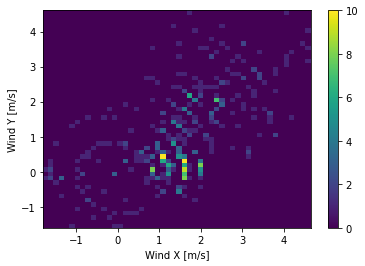

In [14]:
plt.hist2d(kafka_interpo['max Wx'], kafka_interpo['max Wy'], bins=(50, 50), vmax=10)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [15]:
# calculate time of day signal from time index
kafka_interpo.tod_signal(kafka_interpo.index.get_level_values('measuredTime'))

In [16]:
column_names = pd.read_csv('predict/trainset_columns.csv', index_col=0)
kafka_interpo.columns = column_names['0'].values

In [17]:
# Normalize
train_mean = pd.read_pickle('predict/train_mean.pkl')
train_std = pd.read_pickle('predict/train_std.pkl')
kafka_norm = (kafka_interpo - train_mean) / train_std
kafka_norm.shape

(451, 11)

In [18]:
kafka_norm.head(10)

Ilmanpaine (msl) (hPa)  \
roadStationId measuredTime                                  
2052          2021-02-08 08:00:00                1.067398   
              2021-02-08 08:10:00                1.067398   
              2021-02-08 08:20:00                1.067398   
              2021-02-08 08:30:00                1.058764   
              2021-02-08 08:40:00                1.058764   
              2021-02-08 08:50:00                1.058764   
              2021-02-08 09:00:00                1.063081   
              2021-02-08 09:10:00                1.067398   
              2021-02-08 09:20:00                1.067398   
              2021-02-08 09:30:00                1.067398   

                                   Suhteellinen kosteus (%)  \
roadStationId measuredTime                                    
2052          2021-02-08 08:00:00                  1.021276   
              2021-02-08 08:10:00                  1.021276   
              2021-02-08 08:20:00                  1.021276   
              2021-02-08 08:30:00                  1.021276   
              2021-02-08 08:40:00                  1.021276   
              2021-02-08 08:50:00                  0.870612   
              2021-02-08 09:00:00                  0.669726   
              2021-02-08 09:10:00                  0.468840   
              2021-02-08 09:20:00                  0.267955   
              2021-02-08 09:30:00                  0.197645   

                                   Ilman lämpötila (degC)        Wx        Wy  \
roadStationId measuredTime                                                      
2052          2021-02-08 08:00:00               -1.635873  0.369706  0.407447   
              2021-02-08 08:10:00               -1.538948  0.325003  0.457637   
              2021-02-08 08:20:00               -1.442023  0.399090  0.548444   
              2021-02-08 08:30:00               -1.388175  0.528878  0.579902   
              2021-02-08 08:40:00               -1.334328  0.522348  0.587766   
              2021-02-08 08:50:00               -1.302019  0.636669  0.629675   
              2021-02-08 09:00:00               -1.302019  0.636669  0.629675   
              2021-02-08 09:10:00               -1.302019  0.636669  0.629675   
              2021-02-08 09:20:00               -1.248172  0.565265  0.530281   
              2021-02-08 09:30:00               -1.228787  0.576606  0.554738   

                                     max Wx    max Wy   Day sin       Day cos  \
roadStationId measuredTime                                                      
2052          2021-02-08 08:00:00  0.477036  0.500380  1.414209  7.488827e-12   
              2021-02-08 08:10:00  0.466211  0.635944  1.412863 -6.168693e-02   
              2021-02-08 08:20:00  0.518566  0.700332  1.408827 -1.232564e-01   
              2021-02-08 08:30:00  0.762232  0.800915  1.402110 -1.845913e-01   
              2021-02-08 08:40:00  0.752080  0.813182  1.392724 -2.455748e-01   
              2021-02-08 08:50:00  0.791465  0.763004  1.380686 -3.060908e-01   
              2021-02-08 09:00:00  0.854350  0.815528  1.366021 -3.660242e-01   
              2021-02-08 09:10:00  0.917236  0.868053  1.348755 -4.252608e-01   
              2021-02-08 09:20:00  0.818801  0.723509  1.328922 -4.836879e-01   
              2021-02-08 09:30:00  0.862837  0.782319  1.306559 -5.411943e-01   

                                   Year sin  Year cos  
roadStationId measuredTime                             
2052          2021-02-08 08:00:00  0.842557  1.183837  
              2021-02-08 08:10:00  0.842688  1.183731  
              2021-02-08 08:20:00  0.842819  1.183625  
              2021-02-08 08:30:00  0.842949  1.183518  
              2021-02-08 08:40:00  0.843080  1.183412  
              2021-02-08 08:50:00  0.843211  1.183305  
              2021-02-08 09:00:00  0.843341  1.183199  
              2021-02-08 09:10:00  0.843472  1.183092  
              2021-02-08 09:20:00  0.84

In [20]:
inpslic = slice(-6*24,None)
inputdf = kafka_norm[inpslic]
data = np.array(inputdf, dtype=np.float32)
input = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=len(inputdf),
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
y = saved_model.predict(input);
#y = repeat_baseline.predict(input);

result = pd.DataFrame(y[0,:], columns=kafka_norm.columns)
#result.columns = train_df.columns
result = train_std * result + train_mean
# we predicted next 24h
result['date'] = inputdf.index.get_level_values(1) + pd.Timedelta('1 day')
result = result.set_index('date').add_prefix('pred_')

all = pd.concat([result, kafka_interpo.droplevel('roadStationId')], axis=1)

<AxesSubplot:>

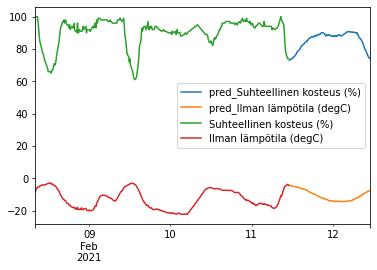

In [21]:
mask = all.columns.str.contains('.*lämpötila.*|.*Suhteellinen.*')
all.sort_index().loc[:,mask].plot()
#all['Ilman lämpötila (degC)'].plot()